# Diagrams

## This file is similar as the evaluation file for the model runs, but creates some aditional diagrms aout the test dataset, used in the thesis




In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk


from pathlib import Path
import torch
import numpy as np
import pandas as pd
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# Load predictions and targets from pickle file
pickle_file = "/workspace/projects/uncertainbird/notebooks/reliability-plots/Final Plots/eat_mcd_p0_1_t10.pkl"
with open(pickle_file, "rb") as f:
    data = pickle.load(f)

predictions = data["predictions"]
targets = data["targets"]
metadata = data["metadata"]

print(f"Loaded data with {metadata['total_samples']} samples")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Model info: {metadata['model_info']}")
print(f"Save logits: {metadata['save_logits']}")

# Display some basic statistics
print(f"\nPrediction statistics:")
print(f"  Min: {predictions.min():.4f}")
print(f"  Max: {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")
print(f"  Std: {predictions.std():.4f}")

print(f"\nTarget statistics:")
print(f"  Min: {targets.min():.4f}")
print(f"  Max: {targets.max():.4f}")
print(f"  Mean: {targets.mean():.4f}")
print(f"  Sum: {targets.sum():.0f} (total positive labels)")
# Eingaben
pred = predictions
targ = targets

# Tensors -> float32
if isinstance(pred, torch.Tensor):
    pred = pred.detach().float().cpu()
if isinstance(targ, torch.Tensor):
    targ = targ.detach().float().cpu()

# Heuristik: Sind es schon Wahrscheinlichkeiten?
# (alles in [0,1] und kein Wert <0 oder >1)
already_probs = (pred.min() >= 0.0) and (pred.max() <= 1.0)

if already_probs:
    probs = pred
else:
    probs = torch.sigmoid(pred)

# Quick-Diagnose
print("pred min/max/mean BEFORE conversion:", float(pred.min()), float(pred.max()), float(pred.mean()))
print("probs min/max/mean AFTER conversion:", float(probs.min()), float(probs.max()), float(probs.mean()))

# Falls die Logits wirklich rund um 0 liegen:
# -> das Modell ist sehr unsicher; Histogramm checken hilft
# z.B.:
# import matplotlib.pyplot as plt
# plt.hist(pred.numpy().ravel(), bins=100); plt.show()

# In DataFrame gießen (wie raw_out.csv)
probs_np = probs.numpy()
targ_np  = targ.numpy()

if probs_np.ndim == 1:  probs_np = probs_np[:, None]
if targ_np.ndim  == 1:  targ_np  = targ_np[:, None]

n_classes = probs_np.shape[1]
pred_cols   = [f"prob_class_{i}" for i in range(n_classes)]
target_cols = [f"target_class_{i}" for i in range(n_classes)]

df = pd.DataFrame(np.hstack([probs_np, targ_np]), columns=pred_cols + target_cols)
print(df.head())
print("targets shape:", targets.shape)
print("targets dtype:", targets.dtype)
print("sum over all targets:", float(targets.sum()))
print("per-class sums (first 20):",
      [int(targets[:, i].sum()) for i in range(min(targets.shape[1], 20))])
print("metadata keys:", list(metadata.keys()))

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MCDropoutModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0056
  Std: 0.0436

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6256 (total positive labels)
pred min/max/mean BEFORE conversion: 0.0 1.0 0.005651229992508888
probs min/max/mean AFTER conversion: 0.0 1.0 0.005651229992508888
   prob_class_0  prob_class_1  prob_class_2  prob_class_3  prob_class_4  \
0      0.001028      0.006565      0.002621      0.002878      0.005260   
1      0.000072      0.000018      0.000170      0.000049      0.000022   
2      0.000005      0.108765      0.000612      0.000036      0.000688   
3      0.001636      0.000021      0.000220      0.000039      0.000019   
4      0.000003      0.000600      0.000150      0.000234      0.000185   

   prob_class_5  

In [50]:
# Optional imports (only used if available)
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
        confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score,
        brier_score_loss, log_loss
    )
    SKLEARN_AVAILABLE = True
except Exception as e:
    print("scikit-learn not available; some metrics/plots will be skipped.", e)
    SKLEARN_AVAILABLE = False

In [51]:
prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
target_cols = [c for c in df.columns if c.startswith("target_class_")]
print("Num samples (N):", len(df))
print("Probability columns:", prob_cols)
print("Probs min/max:", float(df[prob_cols].min().min()), float(df[prob_cols].max().max()))
C = len(prob_cols)
print("Detected classes (C):", C)


Num samples (N): 12000
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'prob_class_10', 'prob_class_11', 'prob_class_12', 'prob_class_13', 'prob_class_14', 'prob_class_15', 'prob_class_16', 'prob_class_17', 'prob_class_18', 'prob_class_19', 'prob_class_20']
Probs min/max: 0.0 1.0
Detected classes (C): 21


In [52]:
Y_true = df[target_cols].values.astype(int)  # [N, C] in {0,1}
Y_prob = df[prob_cols].values.astype(float)  # [N, C] in [0,1]
# Per-class AUROC & AUPRC
auroc_per_class = []
auprc_per_class = []
prevalence_per_class=[]
for j in range(Y_prob.shape[1]):
    try:
        auroc = roc_auc_score(Y_true[:, j], Y_prob[:, j])
        prevalence_class_i = df[f"target_class_{j}"].mean()
        
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(Y_true[:, j], Y_prob[:, j])
    except Exception:
        auprc = np.nan
    auroc_per_class.append(auroc)
    auprc_per_class.append(auprc)
    prevalence_per_class.append(prevalence_class_i)
 


metrics_df = pd.DataFrame({
    "class": list(range(C)),
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class,
    "baseline prevalence":prevalence_per_class,
})
display(metrics_df)

# Macro averages
print("Macro AUROC:", np.nanmean(auroc_per_class))
print("Macro AUPRC:", np.nanmean(auprc_per_class))

,class,AUROC,AUPRC,baseline prevalence
0,0,0.748262,0.256748,0.055917
1,1,0.759413,0.599061,0.223000
2,2,0.753575,0.351609,0.090167
3,3,0.867420,0.139845,0.001833
4,4,0.654580,0.162685,0.061250
5,5,0.836320,0.000508,0.000083
6,6,0.803749,0.262147,0.014583
7,7,0.679930,0.009224,0.002333
8,8,0.756990,0.321081,0.026667
9,9,0.846197,0.054303,0.002250


Macro AUROC: 0.7539153629480451
Macro AUPRC: 0.13874503009518355


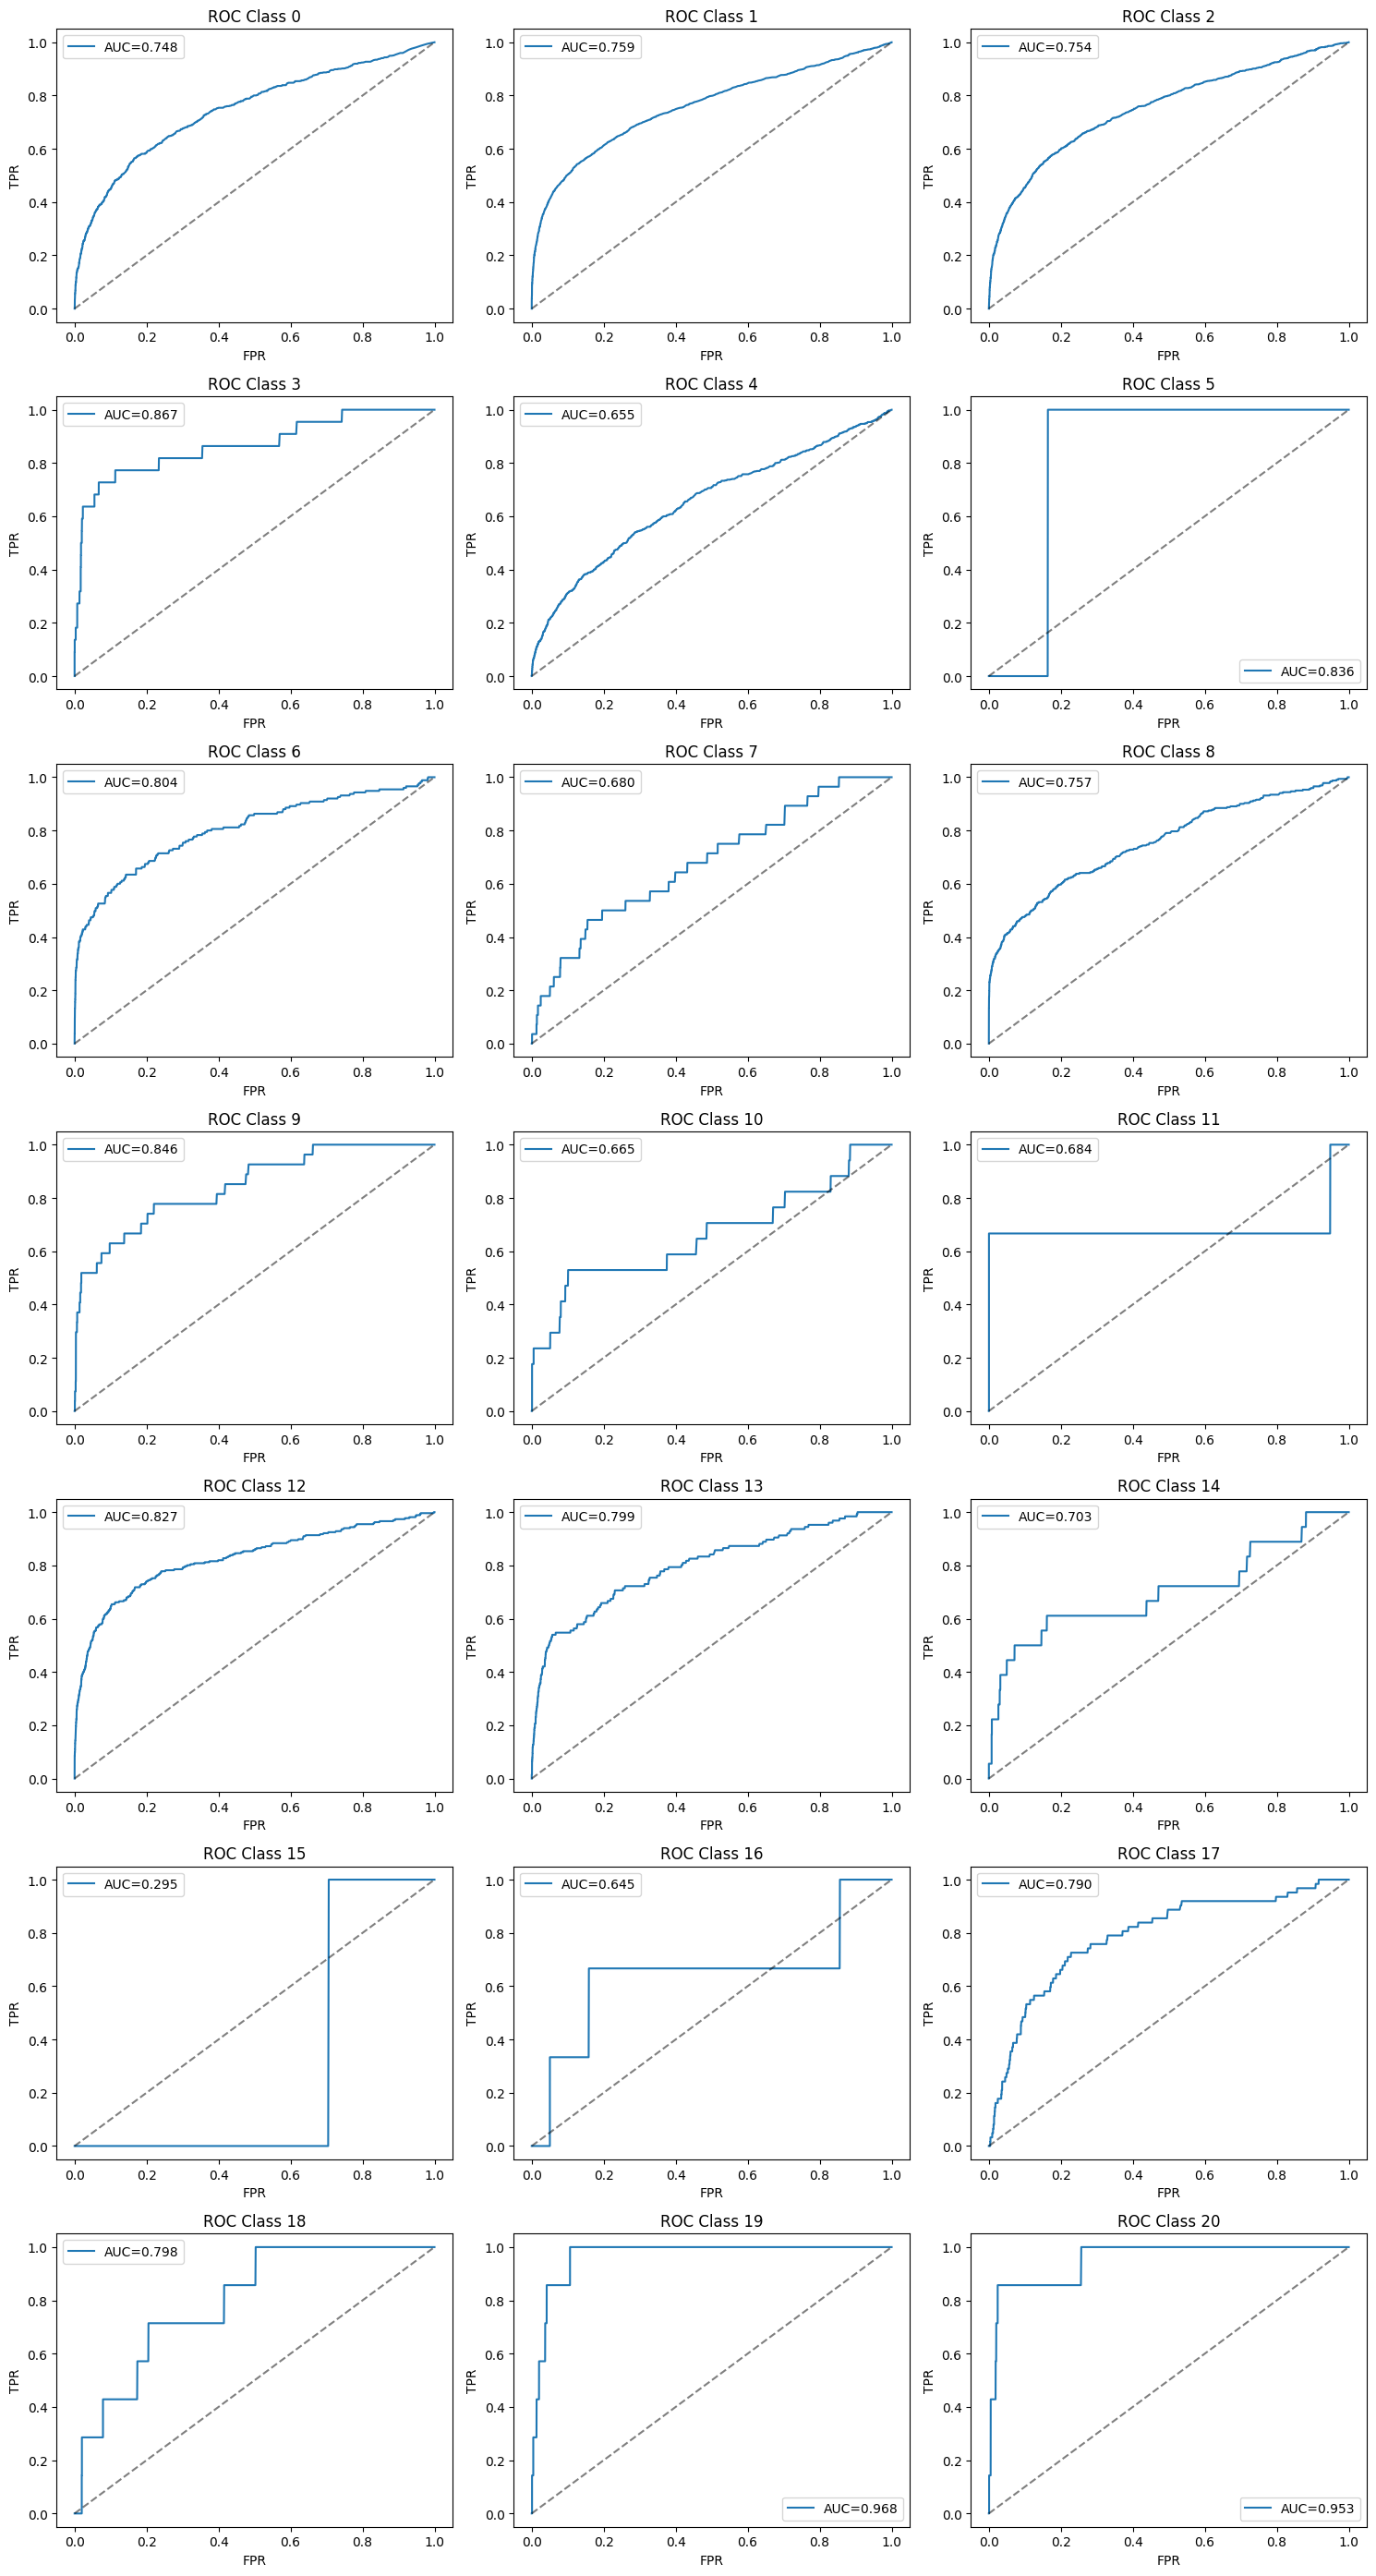

In [53]:
import math

n_classes = Y_prob.shape[1]
cols = 3                               # how many plots per row
rows = math.ceil(n_classes / cols)     # rows needed

# ---------------- ROC curves ----------------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        ax.plot(fpr, tpr, label=f"AUC={auroc_per_class[j]:.3f}")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"ROC Class {j}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
    except Exception as e:
        ax.set_title(f"ROC Class {j} (error)")
        print(f"Skipping ROC for class {j}: {e}")

# Hide empty subplots (if n_classes not multiple of cols)
for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


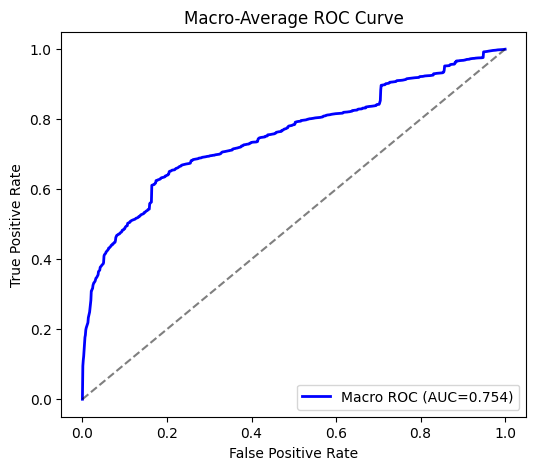

In [54]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# define common FPR grid
fpr_grid = np.linspace(0, 1, 1000)

tpr_list = []
auroc_per_class = []

for j in range(n_classes):
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        auroc = auc(fpr, tpr)
        auroc_per_class.append(auroc)

        # interpolate TPR to common grid
        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0] = 0.0
        tpr_list.append(tpr_interp)
    except Exception as e:
        print(f"Skipping class {j}: {e}")

# compute macro-average TPR and AUROC
tpr_macro = np.mean(tpr_list, axis=0)
macro_auroc = auc(fpr_grid, tpr_macro)

# plot macro ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_grid, tpr_macro, label=f"Macro ROC (AUC={macro_auroc:.3f})", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve")
plt.legend(loc="lower right")
plt.show()

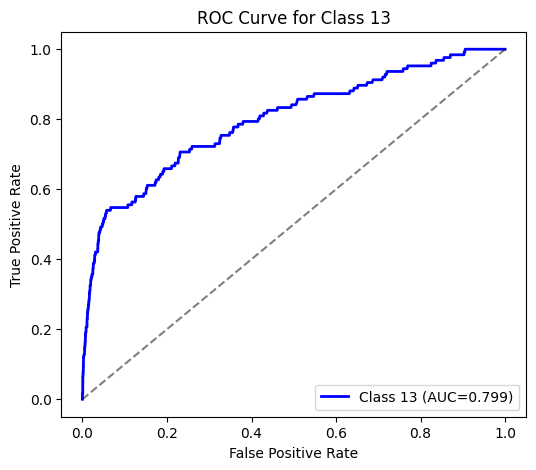

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_id = 13
  # choose the class you want

fpr, tpr, _ = roc_curve(Y_true[:, class_id], Y_prob[:, class_id])
auroc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Class {class_id} (AUC={auroc:.3f})", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Class {class_id}")
plt.legend(loc="lower right")
plt.show()

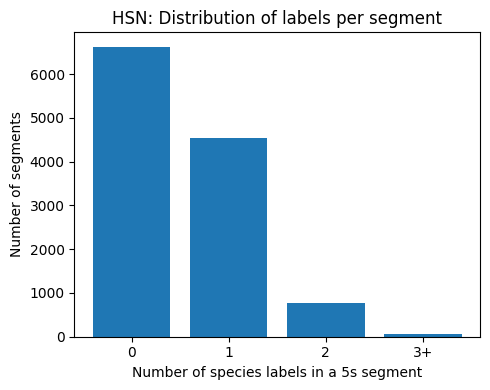

Segments: 12000
Segments with 0 labels: 6623  (55.2%)
Segments with ≥3 labels: 51  (0.4%)


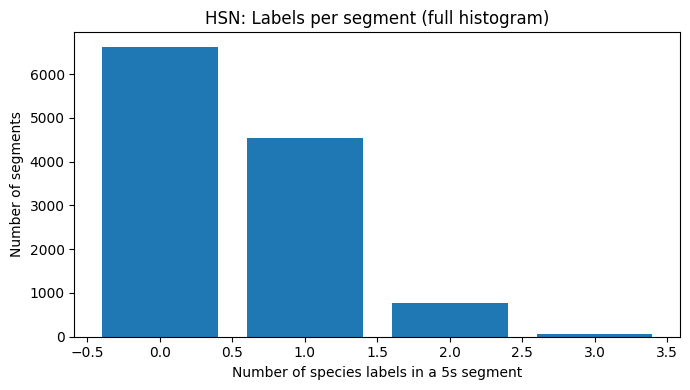

In [56]:
# Sum over columns → number of positive labels in each segment
labels_per_segment = Y_true.sum(axis=1)  # shape [N], integer counts

# A compact binned view: 0, 1, 2, 3+
max_count = labels_per_segment.max() if labels_per_segment.size else 0
bins = [0, 1, 2, 3]
labels = ["0", "1", "2", "3+"]
counts = [
    (labels_per_segment == 0).sum(),
    (labels_per_segment == 1).sum(),
    (labels_per_segment == 2).sum(),
    (labels_per_segment >= 3).sum(),
]

labels_per_seg_df = pd.DataFrame({"labels_in_segment": labels, "num_segments": counts})

# Plot (bar)
plt.figure(figsize=(5, 4))
plt.bar(labels_per_seg_df["labels_in_segment"], labels_per_seg_df["num_segments"])
plt.xlabel("Number of species labels in a 5s segment")
plt.ylabel("Number of segments")
plt.title("HSN: Distribution of labels per segment")
plt.tight_layout()
plt.show()

# Useful summary stats you can print in the thesis
N = len(labels_per_segment)
pct_zero = 100.0 * counts[0] / N if N else 0.0
pct_multi = 100.0 * counts[3] / N if N else 0.0
print(f"Segments: {N}")
print(f"Segments with 0 labels: {counts[0]}  ({pct_zero:.1f}%)")
print(f"Segments with ≥3 labels: {counts[3]}  ({pct_multi:.1f}%)")

# (Optional) full histogram (0..max_count) if you want the exact shape
hist_index = np.arange(int(max_count) + 1)
hist_counts = pd.Series(labels_per_segment).value_counts().reindex(hist_index, fill_value=0)

plt.figure(figsize=(7, 4))
plt.bar(hist_index, hist_counts.values)
plt.xlabel("Number of species labels in a 5s segment")
plt.ylabel("Number of segments")
plt.title("HSN: Labels per segment (full histogram)")
plt.tight_layout()
plt.show()


=== HSN species-frequency stats ===
Segments (N): 12000 | Classes (C): 21
Total positive labels across all classes: 6254
Top-3 classes share: 71.8% of all positive labels
Classes needed to cover 80% of positives: 4
Rare classes (<50 segments): 12 (57.1%)


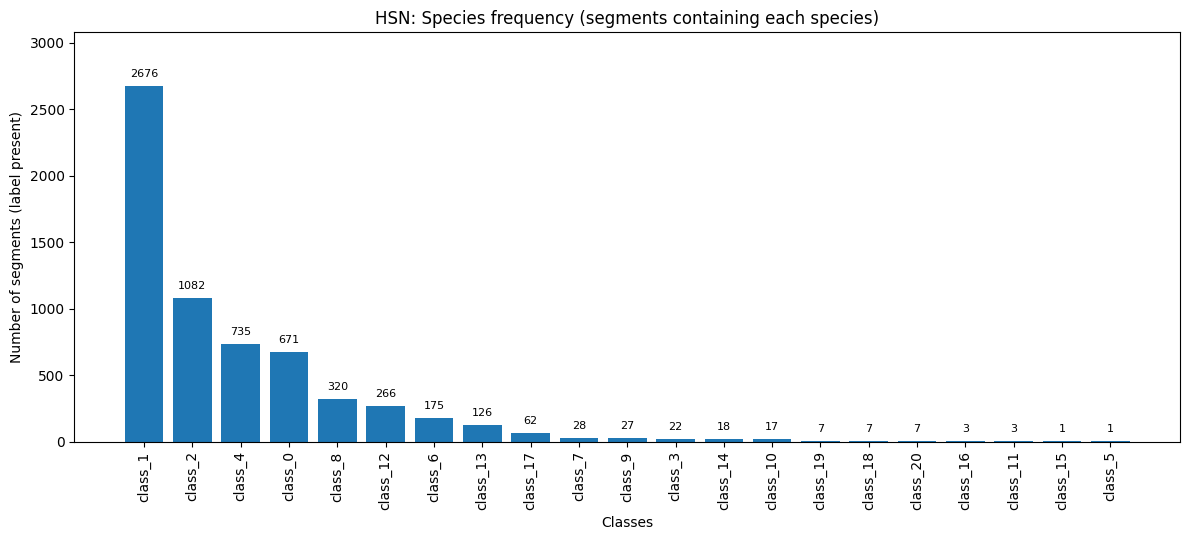

=== HSN labels-per-segment stats ===
Segments (N): 12000
Mean labels/segment: 0.52 | Median: 0 | Max: 3
Segments with 0 labels: 6623 (55.2%)
Segments with ≥2 labels: 826 (6.9%)


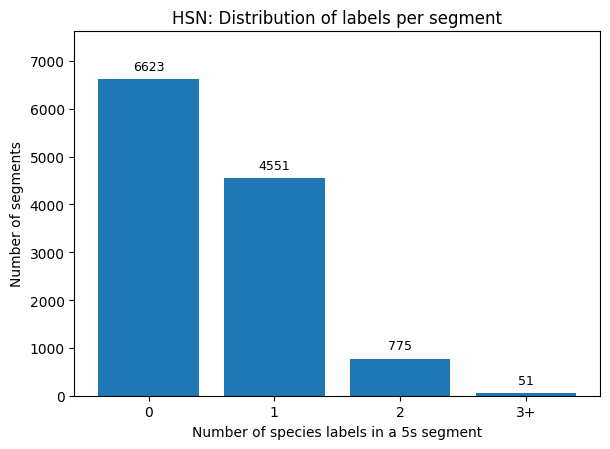


For LaTeX/text:
- Top-3 classes cover 71.8\% of all positives; 4 classes cover 80\%.
- 6623 segments (55.2\%) have no labels; mean labels/segment = 0.52, max = 3.


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_and_stats_species_freq(Y_true, class_names=None, top_k=None,
                                save_fig=None, save_csv=None, title_prefix="HSN"):
    """
    Y_true: (N, C) binary array
    class_names: list[str] of length C (optional)
    top_k: show top-K classes in the plot (optional; stats are on all classes)
    save_fig: path to save figure (optional)
    save_csv: path to save full per-class table (optional)
    """
    # counts per class = number of segments where class is present
    class_counts = Y_true.sum(axis=0).astype(int)
    C = class_counts.shape[0]
    N = Y_true.shape[0]

    names = (np.array(class_names) if class_names is not None and len(class_names) == C
             else np.array([f"class_{j}" for j in range(C)]))

    idx = np.argsort(-class_counts)
    names_sorted = names[idx]
    counts_sorted = class_counts[idx]

    # ---- stats you can cite
    total_positives = int(counts_sorted.sum())
    top3_share = (counts_sorted[:3].sum() / total_positives * 100) if total_positives > 0 else 0.0
    # “rare” threshold is up to you; here: < 50 segments
    rare_threshold = 50
    num_rare = int((counts_sorted < rare_threshold).sum())
    pct_rare = (num_rare / C * 100) if C > 0 else 0.0

    # cumulative coverage: how many classes cover 80% of all positives?
    coverage = 0
    k80 = 0
    target = 0.80 * total_positives
    for i, v in enumerate(counts_sorted):
        coverage += v
        if coverage >= target:
            k80 = i + 1
            break

    # print stats
    print("=== HSN species-frequency stats ===")
    print(f"Segments (N): {N} | Classes (C): {C}")
    print(f"Total positive labels across all classes: {total_positives}")
    print(f"Top-3 classes share: {top3_share:.1f}% of all positive labels")
    print(f"Classes needed to cover 80% of positives: {k80}")
    print(f"Rare classes (<{rare_threshold} segments): {num_rare} ({pct_rare:.1f}%)")

    # full table
    species_freq_df = pd.DataFrame({
        "class": names_sorted,
        "segments_with_label": counts_sorted
    })
    if save_csv:
        species_freq_df.to_csv(save_csv, index=False)

    # ---- plot (optionally top_k)
    plot_names = names_sorted if not top_k else names_sorted[:top_k]
    plot_counts = counts_sorted if not top_k else counts_sorted[:top_k]

    fig, ax = plt.subplots(figsize=(12, 5.5))
    bars = ax.bar(plot_names, plot_counts)

    ax.set_title(f"{title_prefix}: Species frequency (segments containing each species)")
    ax.set_ylabel("Number of segments (label present)")
    ax.set_xlabel("Classes")
    ax.tick_params(axis='x', rotation=90)

    max_h = plot_counts.max() if plot_counts.size else 0
    ax.set_ylim(0, max_h * 1.15)  # headroom
    offset = (max_h * 0.02) if max_h > 0 else 0.5

    for bar, count in zip(bars, plot_counts):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + offset,
                f"{int(count)}",
                ha="center", va="bottom", fontsize=8, rotation=0, clip_on=False)

    fig.tight_layout()
    if save_fig:
        fig.savefig(save_fig, dpi=200, bbox_inches="tight")
    plt.show()

    # return stats if you want to use them programmatically
    return {
        "N": int(N),
        "C": int(C),
        "total_positives": int(total_positives),
        "top3_share_pct": float(top3_share),
        "k_for_80pct_coverage": int(k80),
        "rare_threshold": int(rare_threshold),
        "num_rare": int(num_rare),
        "pct_rare": float(pct_rare),
        "table": species_freq_df
    }

def plot_and_stats_labels_per_segment(Y_true, save_fig=None, title_prefix="HSN"):
    """
    Y_true: (N, C) binary array
    """
    labels_per_segment = Y_true.sum(axis=1).astype(int)
    N = len(labels_per_segment)

    # binned view: 0,1,2,3+
    counts_bins = [
        int((labels_per_segment == 0).sum()),
        int((labels_per_segment == 1).sum()),
        int((labels_per_segment == 2).sum()),
        int((labels_per_segment >= 3).sum()),
    ]
    bin_labels = ["0", "1", "2", "3+"]

    # stats you can cite
    mean_labels = labels_per_segment.mean() if N else 0.0
    median_labels = int(np.median(labels_per_segment)) if N else 0
    max_labels = int(labels_per_segment.max()) if N else 0
    pct_zero = (counts_bins[0] / N * 100) if N else 0.0
    pct_ge2 = ((counts_bins[2] + counts_bins[3]) / N * 100) if N else 0.0

    print("=== HSN labels-per-segment stats ===")
    print(f"Segments (N): {N}")
    print(f"Mean labels/segment: {mean_labels:.2f} | Median: {median_labels} | Max: {max_labels}")
    print(f"Segments with 0 labels: {counts_bins[0]} ({pct_zero:.1f}%)")
    print(f"Segments with ≥2 labels: {counts_bins[2] + counts_bins[3]} ({pct_ge2:.1f}%)")

    # plot
    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    bars = ax.bar(bin_labels, counts_bins)

    ax.set_title(f"{title_prefix}: Distribution of labels per segment")
    ax.set_xlabel("Number of species labels in a 5s segment")
    ax.set_ylabel("Number of segments")

    max_h = max(counts_bins) if counts_bins else 0
    ax.set_ylim(0, max_h * 1.15)
    offset = (max_h * 0.02) if max_h > 0 else 0.5

    for bar, count in zip(bars, counts_bins):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + offset,
                f"{int(count)}",
                ha="center", va="bottom", fontsize=9, rotation=0, clip_on=False)

    fig.tight_layout()
    if save_fig:
        fig.savefig(save_fig, dpi=200, bbox_inches="tight")
    plt.show()

    return {
        "N": int(N),
        "mean_labels": float(mean_labels),
        "median_labels": int(median_labels),
        "max_labels": int(max_labels),
        "counts_bins": dict(zip(bin_labels, counts_bins)),
        "pct_zero": float(pct_zero),
        "pct_ge2": float(pct_ge2)
    }
# species names optional
# class_names = [...]

freq_stats = plot_and_stats_species_freq(
    Y_true, top_k=None,
    save_fig="Label_distribution.png", save_csv="HSN_species_frequency.csv",
    title_prefix="HSN"
)

lps_stats = plot_and_stats_labels_per_segment(
    Y_true, save_fig="Labels_per_segment.png", title_prefix="HSN"
)

# If you want to reference numbers in the thesis automatically:
print("\nFor LaTeX/text:")
print(f"- Top-3 classes cover {freq_stats['top3_share_pct']:.1f}\\% of all positives; "
      f"{freq_stats['k_for_80pct_coverage']} classes cover 80\\%.")
print(f"- {lps_stats['counts_bins']['0']} segments ({lps_stats['pct_zero']:.1f}\\%) have no labels; "
      f"mean labels/segment = {lps_stats['mean_labels']:.2f}, max = {lps_stats['max_labels']}.")

